In [1]:
from __future__ import print_function

from scipy.stats import norm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Lambda
from keras.layers import Dropout
from keras.objectives import binary_crossentropy
import keras.backend as K
from keras import metrics

from keras.callbacks import TensorBoard, ModelCheckpoint
from time import time
import h5py

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

C:\Users\roberto\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
data = pd.read_csv("D:/MBIT-2017-18-Master-Deep-Learning/Reto - Zara - Abril 2019/zara_data_go_2019_initial_dataset/AE-variables.txt",sep=',', encoding='latin-1')
data.head()

,block_id,Semana,position,price,sales,stock,Profit,num_produc,Target
0,0,0,40,29.16,2,87,57.23,7,0
1,0,1,53,30.53,2,80,52.47,7,0
2,0,2,66,31.28,1,65,50.11,7,0
3,0,3,62,34.84,1,69,38.01,7,0
4,0,4,62,37.12,1,70,38.14,7,0


In [4]:
data.loc[data['Target'] == 1].head()

,block_id,Semana,position,price,sales,stock,Profit,num_produc,Target
229,1021,0,96,36.98,5,173,228.64,10,1
284,1028,0,180,29.95,11,74,336.94,10,1
377,1037,3,46,23.81,8,14,247.13,7,1
792,1080,1,103,25.95,8,25,214.43,4,1
794,1080,3,131,28.20,9,92,265.43,4,1


In [5]:
data.shape

(23074, 9)

In [6]:
x_data = data.iloc[0:,[2,3,4,5,6,7]]
x_data.shape

(23074, 6)

In [7]:
original_dim = x_data.shape[1]
latent_dim = 2
intermediate_dim = 256
epsilon_std = 1.0

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          1792        input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [8]:
x_train, x_test = train_test_split(x_data, test_size=0.25, random_state=42)
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
print(x_train.shape)  

(17305, 6)


In [9]:
LOAD_MODEL = False
batch_size = 64
epochs = 500
filepath="autoencoder_vae_ZARA_best.h5" 

if not LOAD_MODEL:
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                                     save_best_only=True,
                                     mode='min') # graba sólo los que mejoran en validación
    
    callbacks_list = [checkpoint]
    
    vae.fit(x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            callbacks = callbacks_list,
            verbose=0,
            validation_data=(x_test, None))


Epoch 00001: val_loss improved from inf to -13.61339, saving model to autoencoder_vae_ZARA_best.h5

Epoch 00002: val_loss improved from -13.61339 to -23.56083, saving model to autoencoder_vae_ZARA_best.h5

Epoch 00003: val_loss improved from -23.56083 to -26.12426, saving model to autoencoder_vae_ZARA_best.h5

Epoch 00004: val_loss improved from -26.12426 to -27.15284, saving model to autoencoder_vae_ZARA_best.h5

Epoch 00005: val_loss improved from -27.15284 to -27.67869, saving model to autoencoder_vae_ZARA_best.h5

Epoch 00006: val_loss improved from -27.67869 to -28.05123, saving model to autoencoder_vae_ZARA_best.h5

Epoch 00007: val_loss improved from -28.05123 to -28.12847, saving model to autoencoder_vae_ZARA_best.h5

Epoch 00008: val_loss did not improve from -28.12847

Epoch 00009: val_loss improved from -28.12847 to -28.70243, saving model to autoencoder_vae_ZARA_best.h5

Epoch 00010: val_loss improved from -28.70243 to -28.87010, saving model to autoencoder_vae_ZARA_best.h


Epoch 00126: val_loss did not improve from -30.79154

Epoch 00127: val_loss did not improve from -30.79154

Epoch 00128: val_loss did not improve from -30.79154

Epoch 00129: val_loss did not improve from -30.79154

Epoch 00130: val_loss did not improve from -30.79154

Epoch 00131: val_loss did not improve from -30.79154

Epoch 00132: val_loss did not improve from -30.79154

Epoch 00133: val_loss did not improve from -30.79154

Epoch 00134: val_loss did not improve from -30.79154

Epoch 00135: val_loss did not improve from -30.79154

Epoch 00136: val_loss did not improve from -30.79154

Epoch 00137: val_loss did not improve from -30.79154

Epoch 00138: val_loss did not improve from -30.79154

Epoch 00139: val_loss did not improve from -30.79154

Epoch 00140: val_loss did not improve from -30.79154

Epoch 00141: val_loss did not improve from -30.79154

Epoch 00142: val_loss did not improve from -30.79154

Epoch 00143: val_loss did not improve from -30.79154

Epoch 00144: val_loss did n


Epoch 00271: val_loss improved from -31.04561 to -31.07056, saving model to autoencoder_vae_ZARA_best.h5

Epoch 00272: val_loss did not improve from -31.07056

Epoch 00273: val_loss did not improve from -31.07056

Epoch 00274: val_loss did not improve from -31.07056

Epoch 00275: val_loss did not improve from -31.07056

Epoch 00276: val_loss did not improve from -31.07056

Epoch 00277: val_loss did not improve from -31.07056

Epoch 00278: val_loss did not improve from -31.07056

Epoch 00279: val_loss did not improve from -31.07056

Epoch 00280: val_loss did not improve from -31.07056

Epoch 00281: val_loss did not improve from -31.07056

Epoch 00282: val_loss did not improve from -31.07056

Epoch 00283: val_loss did not improve from -31.07056

Epoch 00284: val_loss did not improve from -31.07056

Epoch 00285: val_loss did not improve from -31.07056

Epoch 00286: val_loss did not improve from -31.07056

Epoch 00287: val_loss did not improve from -31.07056

Epoch 00288: val_loss did not


Epoch 00422: val_loss did not improve from -31.07056

Epoch 00423: val_loss did not improve from -31.07056

Epoch 00424: val_loss did not improve from -31.07056

Epoch 00425: val_loss did not improve from -31.07056

Epoch 00426: val_loss did not improve from -31.07056

Epoch 00427: val_loss did not improve from -31.07056

Epoch 00428: val_loss did not improve from -31.07056

Epoch 00429: val_loss did not improve from -31.07056

Epoch 00430: val_loss did not improve from -31.07056

Epoch 00431: val_loss did not improve from -31.07056

Epoch 00432: val_loss did not improve from -31.07056

Epoch 00433: val_loss did not improve from -31.07056

Epoch 00434: val_loss did not improve from -31.07056

Epoch 00435: val_loss did not improve from -31.07056

Epoch 00436: val_loss did not improve from -31.07056

Epoch 00437: val_loss did not improve from -31.07056

Epoch 00438: val_loss improved from -31.07056 to -31.11666, saving model to autoencoder_vae_ZARA_best.h5

Epoch 00439: val_loss did not

In [11]:
vae.save_weights('autoencoder_weights_vae_ZARA_v1.h5')

In [12]:
encoder = Model(x, z_mean)

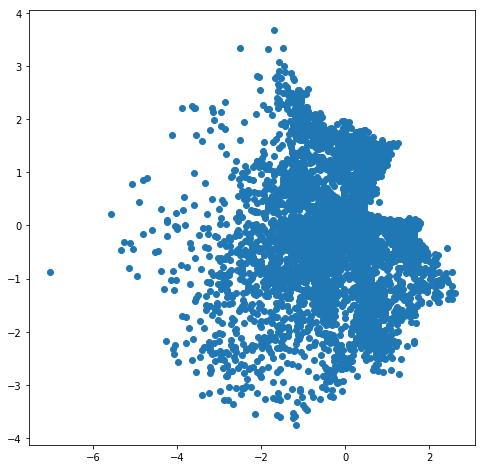

In [13]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(8, 8))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1])
plt.show()

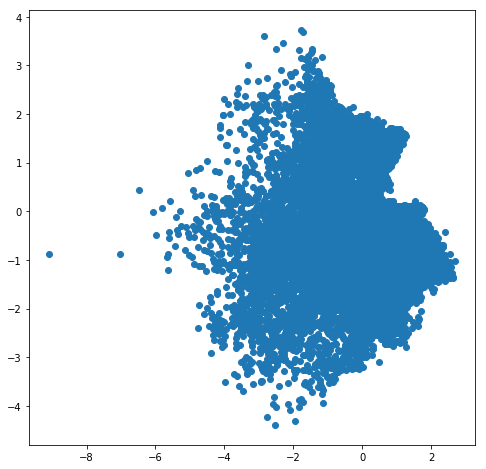

In [14]:
client = scaler.transform(x_data)
client_rep_latente = encoder.predict(client, batch_size=batch_size)
plt.figure(figsize=(8, 8))
plt.scatter(client_rep_latente[:, 0], client_rep_latente[:, 1])
plt.show()

In [15]:
print(data.shape)
print(client_rep_latente.shape)
print(client_rep_latente[0:5,])

(23074, 9)
(23074, 2)
[[-1.8136486  -0.6024401 ]
 [-1.8742026  -0.50374556]
 [-1.0358579   0.19823653]
 [-0.96230805  0.5589168 ]
 [-1.1051522   0.7741054 ]]


In [16]:
data_client = np.hstack((data, client_rep_latente))
print(data_client.shape)

(23074, 11)


Text(0.5,1,'Elbow curve')

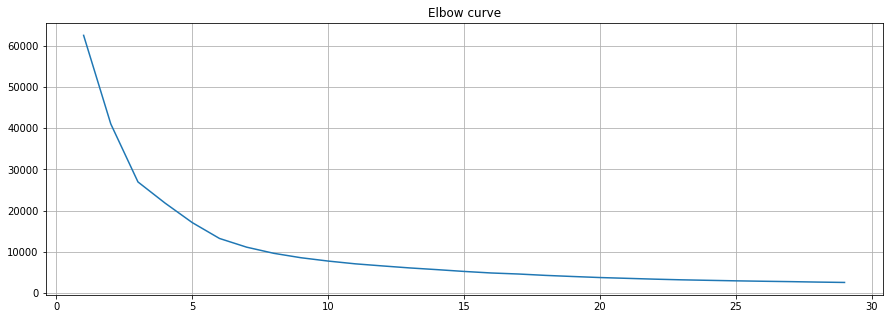

In [17]:
from sklearn.cluster import KMeans

distorsions = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(client_rep_latente)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 30), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [40]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(client_rep_latente)
num_cluster = (kmeans.labels_.reshape(client_rep_latente.shape[0],1)) + 1
print(num_cluster)

[[3]
 [3]
 [3]
 ...
 [5]
 [5]
 [5]]


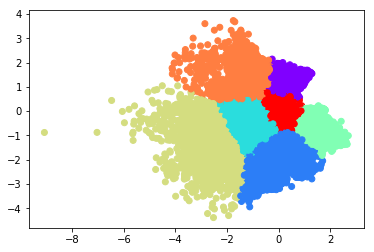

In [41]:
plt.scatter(client_rep_latente[:,0],client_rep_latente[:,1], c=kmeans.labels_, cmap='rainbow') 

In [42]:
data["cluster"] = num_cluster
data["latente-x"] = client_rep_latente[:,0]
data["latente-y"] = client_rep_latente[:,1]   

In [43]:
data.head() 

,block_id,Semana,position,price,sales,stock,Profit,num_produc,Target,cluster,latente-x,latente-y
0,0,0,40,29.16,2,87,57.23,7,0,3,-1.813649,-0.602440
1,0,1,53,30.53,2,80,52.47,7,0,3,-1.874203,-0.503746
2,0,2,66,31.28,1,65,50.11,7,0,3,-1.035858,0.198237
3,0,3,62,34.84,1,69,38.01,7,0,6,-0.962308,0.558917
4,0,4,62,37.12,1,70,38.14,7,0,6,-1.105152,0.774105


In [44]:
data.loc[data['Target'] == 1].head(25)

,block_id,Semana,position,price,sales,stock,Profit,num_produc,Target,cluster,latente-x,latente-y
229,1021,0,96,36.98,5,173,228.64,10,1,5,-3.408722,-0.488481
284,1028,0,180,29.95,11,74,336.94,10,1,5,-3.843522,-0.076850
377,1037,3,46,23.81,8,14,247.13,7,1,5,-3.218762,-0.872460
792,1080,1,103,25.95,8,25,214.43,4,1,5,-3.059540,-1.164112
794,1080,3,131,28.20,9,92,265.43,4,1,5,-3.681287,-2.163785
795,1080,4,109,28.73,10,171,297.85,4,1,5,-3.967597,-2.571855
830,1084,2,56,29.95,7,72,238.17,2,1,5,-3.553507,-1.377328
998,1102,3,97,12.95,26,155,337.35,4,1,5,-4.137071,-2.669747
999,1102,4,44,12.95,17,644,225.16,4,1,5,-3.309258,-3.269233
1055,1108,0,45,39.18,5,83,209.72,8,1,5,-3.573229,-0.248221


In [46]:
data.to_csv("D:/MBIT-2017-18-Master-Deep-Learning/Reto - Zara - Abril 2019/zara_data_go_2019_initial_dataset/cluster-ZARA-autoencoder-vae-7-cluster.csv",sep=';',decimal=',',index=False)
    